# Day 19 专题:核密度估计(Kernel Density Estimation)
密度评估器是一种利用 D 维数据集生成 D 维概率分布估计的算法。GMM 算法用不同 高斯分布的加权汇总来表示概率分布估计。核密度估计(kernel density estimation，KDE) 算法将高斯混合理念扩展到了逻辑极限(logical extreme)。它通过对每个点生成高斯分布 的混合成分，获得本质上是无参数的密度评估器。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## 1.KDE的由来:直方图
下面创建两组服从正态分布的数据:
在这个直方图中，区间的高度并不反映 统计频次，而是反映概率密度

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

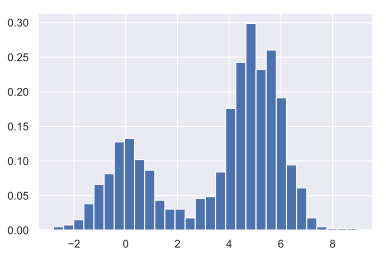

In [3]:
hist = plt.hist(x, bins=30, density=True) # hist = plt.hist(x, bins=30)

值得注意的是，在区间不变的条件下，这个标准化(计算概率密度)只是简单地改变了 y 轴的比例，相对高度仍然与频次直方图一致。标准化是为了让直方图的总面积等于 1，可 以通过检查直方图函数的输出结果来确认这一点:

In [4]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum() == 1.0

True

使用直方图作为密度评估器时需要注意的是，区间大小和位置的选择不同，产生的统计特 征也不同。例如:

In [5]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

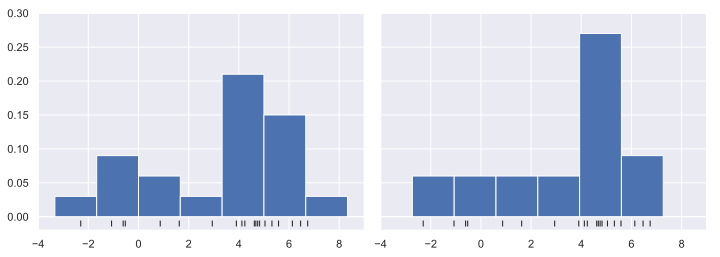

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)

这样, 两个不同的直方图描述的却是相同的数据, 这样怎么能相信直方图的可视化结果呢?如何才能改进这个问题呢?

让我们先退一步，将直方图看成是一堆方块，把每个方块堆在数据集每个数据点所在的区 间内:

(-0.2, 8)

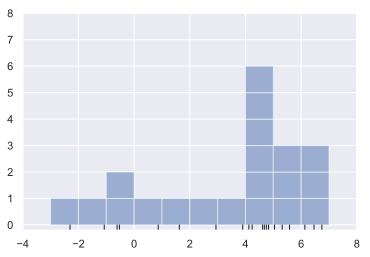

In [7]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                   alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

前面介绍的两种区间之所以会造成解读差异，究其原因在于方块堆叠的高度通常并不能反 映区间附近数据点的实际密度，而是反映了区间如何与数据点对齐。区间内数据点和方块 对不齐将可能导致前面那样糟糕的直方图。但是，如果不采用方块与区间对齐的形式，而 是采用方块与相应的数据点对齐的方式呢?虽然这样做会导致方块对不齐，但是可以将它 们在 x 轴上每个数据点位置的贡献求和来找到结果。

每个点的块中心的“直方图”，这是一个核密度估计示例:(???)

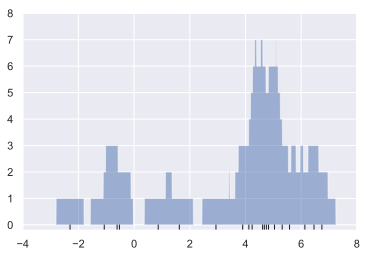

In [8]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

我们也许可以用平滑函数取代每个位置上的方块，例如使用高 斯函数。下面用标准的正态分布曲线代替每个点的方块:

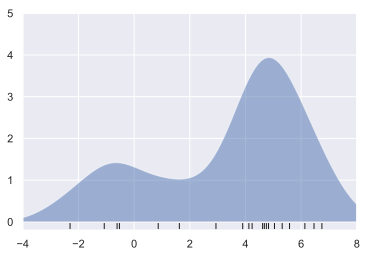

In [9]:
from scipy.stats import norm

x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

这幅平滑的图像是由每个点所在位置的高斯分布构成的，这样可以更准确地表现数据分布的形状，并且拟合方差更小(也就是说，进行不同的抽样时，数据的改变更小)。

## 2.核密度估计的实际应用
核密度估计的自由参数是**核类型(kernel)**参数，它可以指定每个点核密度分布的形状。 而**核带宽(kernel bandwidth)**参数控制每个点的核的大小。

在实际应用中，有很多核可用 于核密度估计，特别是 Scikit-Learn 的 KDE 实现支持六个核.在 sklearn.neighbors. KernelDensity 评估器中实现，借助六个核中的任意一个核、二三十个距离量度就可以处理具有多个维度的 KDE。由于 KDE 计算量非常大，因此 Scikit-Learn 评估器底层使用了一 种基于树的算法，可以利用 atol(绝对容错)和 rtol(相对容错)参数来平衡计算时间与 准确性。

(-0.02, 0.22)

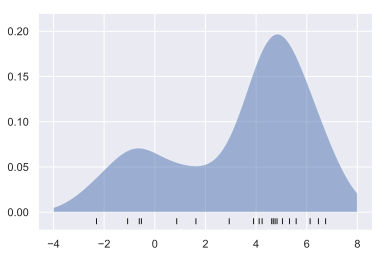

In [10]:
from sklearn.neighbors import KernelDensity

# 初始化并拟合KDE模型
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples返回概率密度的对数值
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

这里的结果经过了标准化处理，保证曲线下的面积为 1。
### 通过交叉检验选择带宽
在 KDE 中，带宽的选择不仅对找到合适的密度估计非常重要，也是在密度估计中控制偏 差 - 方差平衡的关键:带宽过窄将导致估计呈现高方差(即过拟合)，而且每个点的出现 或缺失都会引起很大的不同;带宽过宽将导致估计呈现高偏差(即欠拟合)，而且带宽较 大的核还会破坏数据结构。

这里用 GridSearchCV 来优化前面数据集的密度估计带宽。因为我们要处理的数据集规模 比较小，所以使用留一法进行交叉检验，该方法在每一次做交叉检验时，都会最小化训 练集的损失:

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(x[:, None]);

In [12]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

这个最优带宽与前面示例图像中使用的带宽非常接近，那里使用的带宽是 1.0(也是 scipy.stats.norm 的默认宽度)。

## 3.示例:球形空间的KDE

下面将介绍一个稍复杂些的 KDE 数据分布可视化应用。我们会使用 Scikit-Learn 的一些地 理数据:褐喉树懒(bradypus variegatus)和森林小稻鼠(microryzomys minutus)这两种南 美洲哺乳类动物的地理分布观测值。

In [13]:
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()

# Get matrices/arrays of species IDs and locations
latlon = np.vstack([data.train['dd lat'],
                    data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro')
                    for d in data.train['species']], dtype='int')

导入数据后，使用 Basemap 工具在南美洲地图中画出这两个物种 的观测位置:

In [14]:
# from mpl_toolkits.basemap import Basemap
# from sklearn.datasets.species_distributions import construct_grids

# xgrid, ygrid = construct_grids(data)

# # plot coastlines with basemap
# m = Basemap(projection='cyl', resolution='c',
#             llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
#             llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
# m.drawmapboundary(fill_color='#DDEEFF')
# m.fillcontinents(color='#FFEEDD')
# m.drawcoastlines(color='gray', zorder=2)
# m.drawcountries(color='gray', zorder=2)

# # plot locations
# m.scatter(latlon[:, 1], latlon[:, 0], zorder=3,
#           c=species, cmap='rainbow', latlon=True);